In [44]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import itertools
from torch.utils.data import DataLoader
import time
import copy
import torch.nn.functional as F
from torch import autograd





torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [45]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from higher import innerloop_ctx as metaloop

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)


class CustomDataset(Dataset):
  '''returns an imbalanced mnist dataset depending on class_ratios and noise_ratios that you enter '''
    def __init__(self, X, y, class_ratios, noise_ratios):
        self.X = np.copy(X)
        self.y = np.copy(y)
        N = len(X)

        #  get unique labels and their count in the dataset
        self.unique_y, self.y_counts = np.unique(self.y, return_counts=True)
        assert len(class_ratios) == len(self.unique_y)
        assert len(noise_ratios) == len(self.unique_y)
        print(f"Unique labels input {self.unique_y}, Count {self.y_counts}")

        # normalize class ratio list
        self.class_ratios = class_ratios

        # prune dataset
        for label in self.unique_y:
          idx = np.where(self.y == label)[0]
          n_samples = min(len(idx),int(self.class_ratios[label] * len(idx)))
          to_remove = np.random.choice(idx, len(idx) - n_samples, replace=False)
          self.y[to_remove] = -10000
        self.X = self.X[self.y!=-10000]
        self.y = self.y[self.y!=-10000]

        self.unique_y, self.y_counts = np.unique(self.y, return_counts=True)
        print(f"Unique labels after pruning {self.unique_y}, Count {self.y_counts}")

        # add noise to each class
        self.noise_ratios = noise_ratios
        for label in self.unique_y:
          idx = np.where(self.y == label)[0]
          n_noise = min(len(idx),int(self.noise_ratios[label] * N))
          to_noise = np.random.choice(idx, n_noise, replace=False)
          self.y[to_noise] = np.random.choice(self.unique_y, n_noise, replace=True)

        self.N_classes = len(self.unique_y)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image, label = self.X[idx], self.y[idx]


        onehot_label = np.where(self.unique_y == label)[0][0]
        onehot_label = torch.tensor(onehot_label, dtype=torch.float32)

        image = torch.tensor(image, dtype=torch.float32)/255.0
        image = image.unsqueeze(0)

        # image= self.transform(image)

        return image, onehot_label


batch_size = 64
labels = mnist_train.targets.numpy()
data = mnist_train.data.numpy()
test_data = mnist_test.data.numpy()
test_labels =  mnist_test.targets.numpy()
class_ratios = {0:0, 1:0, 2:0, 3:0, 4:0.005, 5:0, 6:0, 7:0, 8:1, 9:0}
noise_ratios = {0:0, 1:0, 2:0, 3:0, 4:0.1, 5:0, 6:0, 7:0, 8:0.1, 9:0}  # noise ratio should be < 1 for each class. If no noise 0

class_ratios_test = {0:0, 1:0, 2:0, 3:0, 4:1, 5:0, 6:0, 7:0, 8:1, 9:0}
noise_ratios_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # noise ratio should be < 1 for each class. If no noise 0
train_loader = DataLoader(CustomDataset(data, labels, class_ratios,noise_ratios), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(CustomDataset(test_data, test_labels, class_ratios_test,noise_ratios_test), batch_size=batch_size, shuffle=False)

val_loader = DataLoader(CustomDataset(test_data, test_labels, class_ratios_test,noise_ratios_test), batch_size=batch_size, shuffle=True)


Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Unique labels after pruning [4 8], Count [  29 5851]
Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Unique labels after pruning [4 8], Count [982 974]
Unique labels input [0 1 2 3 4 5 6 7 8 9], Count [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Unique labels after pruning [4 8], Count [982 974]


torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor(1.)


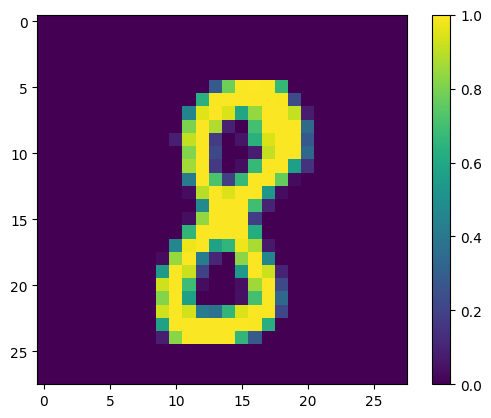

In [46]:
for data, label in train_loader:
  break
print(data.shape, label.shape)

plt.imshow(data[1,0])
plt.colorbar()
print(label[1])

In [54]:
# Collect 100 samples of digit 4 and 8 for validation data
X_validation = []
y_validation = []

counter_4 = 0
counter_8 = 0

for sample in val_loader:
    X_validation.append(sample[0])
    y_validation.append(sample[1])

X_validation = torch.vstack(X_validation)[:100]
y_validation = torch.hstack(y_validation)[:100]
print(X_validation.shape)
print(y_validation.shape)


torch.Size([100, 1, 28, 28])
torch.Size([100])


In [55]:
class SimpleCNN(nn.Module):
    def __init__(self, n_out):
        super(SimpleCNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_out)

        #max pooling layers
        self.maxpool= nn.MaxPool2d(2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x).squeeze()
        return x



In [56]:
class trainer():
    def __init__(self, model, train_dataloader, test_dataloader, X_validation, y_validation, device):
        self.device= device
        self.model= model.to(device)
        self.train_dataloader= train_dataloader
        self.test_dataloader= test_dataloader
        self.X_val= X_validation
        self.y_val= y_validation


    def train_normal(self, epochs):
      '''trains the model using traditional approach'''
        # criterion= torch.nn.CrossEntropyLoss()
        criterion= torch.nn.BCEWithLogitsLoss().to(device)
        optimizer= torch.optim.Adam(self.model.parameters(), lr=0.001)
        running_loss_per_epoch=[]
        for epoch in range(epochs):
            self.model.train()
            total_num=0
            running_loss= 0
            train_acc=0
            running_loss_per_batch= []
            for i, data in enumerate(self.train_dataloader):
                images, labels= data
                images= images.to(self.device)  #using cuda
                # labels= labels.type(torch.LongTensor).to(self.device) #for softmax
                labels= labels.to(self.device)

                predicted_logits= self.model(images)
                # predicted_probs = F.softmax(predicted_logits, dim=1) #applying softmax along dimension 1
                pred_labels= (F.sigmoid(predicted_logits)>0.5).int()
                loss= criterion(predicted_logits, labels.type_as(predicted_logits))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())
                total_num+= len(images)

            running_loss_per_epoch.append(np.mean(running_loss_per_batch)) #tracking loss per epoch
            print("[epoch: %d] loss: %.3f    train accuracy: %.3f" \
                    % (epoch + 1,  running_loss_per_epoch[-1], (train_acc/total_num)*100))
            self.test()

        return running_loss_per_epoch


    def test(self):
        criterion= torch.nn.BCEWithLogitsLoss().to(device)
        self.model.eval()  #setting the model in evaluation mode
        val_stat={}
        all_accuracy=[]
        all_loss=[]
        all_predictions=[]
        all_labels=[]
        total_num=0
        with torch.no_grad():
            running_loss_per_batch=[]
            for images, labels in self.test_dataloader:
                images, labels= images.to(device), labels.to(device)
                pred_logits = self.model(images).float()
                labels_tensor = labels.clone().detach()
                # predicted_probs= F.softmax(labels_pred, dim=1)
                pred_labels= (F.sigmoid(pred_logits)>0.5).int()
                loss=criterion(pred_logits, labels_tensor.type_as(pred_logits))
                # accuracy=torch.sum((labels_pred.argmax(dim=1) == labels_tensor).float())
                accuracy= torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())    #tracking the loss, accuracy, predicted labels, and true labels
                all_accuracy.append(accuracy)
                all_predictions.append(pred_labels)
                all_labels.append(labels)
                total_num+=len(images)

        val_stat['loss'] = np.mean(running_loss_per_batch)
        val_stat['accuracy']=sum(all_accuracy)/total_num
        val_stat['prediction']=torch.cat(all_predictions, dim=0)
        val_stat['labels']=torch.cat(all_labels, dim=0)
        print(f"Test/Validation result: total sample: {total_num}, Avg loss: {val_stat['loss']:.3f}, Acc: {100*val_stat['accuracy']:.3f}%")
        return val_stat #returning the tracked values in the form of a dictionary



    def train_reweighted(self, epochs):
        '''trains the model using reweighted sampling approach'''
        criterion = torch.nn.BCEWithLogitsLoss().to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        running_loss_per_epoch = []

        for epoch in range(epochs):
            self.model.train()
            train_acc = 0
            total_num = 0
            running_loss = 0
            running_loss_per_batch = []

            for i, data in enumerate(self.train_dataloader):
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                # Inner loop for reweighted training
                with metaloop(self.model, optimizer) as (inner_model, inner_optimizer):
                    inner_train_outputs = inner_model(images)
                    cost = criterion(inner_train_outputs, labels.type_as(inner_train_outputs))

                    eps = torch.zeros(cost.size(), requires_grad=True, device=self.device)
                    inner_trainloss = torch.sum(eps * cost)
                    inner_optimizer.step(inner_trainloss)

                    val_loss, eps_grads = self._compute_val_loss_and_gradients(inner_model, eps)

                # Compute weights for reweighting based on validation gradients
                w_tilde = torch.clamp(-eps_grads, min=0)
                norm = torch.sum(w_tilde)
                w = w_tilde / norm if norm != 0 else w_tilde

                # Perform standard training step using reweighted loss
                predicted_logits = self.model(images)
                pred_labels = (F.sigmoid(predicted_logits) > 0.5).int()
                criterion.reduction= 'none'
                loss = criterion(predicted_logits, labels.type_as(predicted_logits))
                loss = torch.sum(w * loss)

                # Update variables
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_acc += torch.sum(torch.eq(pred_labels, labels)).item()
                running_loss_per_batch.append(loss.item())
                total_num += len(images)

            running_loss_per_epoch.append(np.mean(running_loss_per_batch))
            print("[epoch: %d] loss: %.3f    train accuracy: %.3f" % (epoch + 1, running_loss_per_epoch[-1], (train_acc / total_num) * 100))
            self.test()

        return running_loss_per_epoch



    def _compute_val_loss_and_gradients(self, model, eps):
        '''computes validation loss and gradients for reweighting'''
        criterion = torch.nn.BCEWithLogitsLoss(reduction= 'mean').to(self.device)
        val_loss = 0
        # val_images, val_labels =  next(self.val_dataloader)
        val_images, val_labels = self.X_val.to(device=self.device), self.y_val.to(device=self.device)
        val_pred_logits = model(val_images)
        loss = criterion(val_pred_logits, val_labels.type_as(val_pred_logits))
        eps_grads= (torch.autograd.grad(loss, eps, allow_unused=True)[0].detach())
        return val_loss, eps_grads


In [ ]:
# Instantiate and train model using traditional method
model = SimpleCNN(n_out=1)
my_trainer_normal= trainer(model, train_loader, test_loader, X_validation, y_validation, device)
normal_losses=my_trainer_normal.train_normal(epochs= 20)


[epoch: 1] loss: 0.694    train accuracy: 48.622
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 49.796%
[epoch: 2] loss: 0.693    train accuracy: 48.724
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 49.796%
[epoch: 3] loss: 0.693    train accuracy: 49.473
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 50.204%
[epoch: 4] loss: 0.693    train accuracy: 49.575
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 49.796%
[epoch: 5] loss: 0.693    train accuracy: 48.724
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 49.796%
[epoch: 6] loss: 0.693    train accuracy: 49.779
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 49.796%
[epoch: 7] loss: 0.693    train accuracy: 50.153
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 50.204%
[epoch: 8] loss: 0.693    train accuracy: 49.881
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 50.204%
[epoch: 9] loss:

In [ ]:
# Instantiate and train model using proposed method
model2= SimpleCNN(n_out=1)
my_trainer2= trainer(model2, train_loader, test_loader, X_validation, y_validation, device)
reweighted=my_trainer2.train_reweighted(epochs= 20)

[epoch: 1] loss: 0.682    train accuracy: 49.847
Test/Validation result: total sample: 1956, Avg loss: 0.696, Acc: 50.204%
[epoch: 2] loss: 0.688    train accuracy: 49.847
Test/Validation result: total sample: 1956, Avg loss: 0.693, Acc: 50.204%
[epoch: 3] loss: 0.600    train accuracy: 49.949
Test/Validation result: total sample: 1956, Avg loss: 0.208, Acc: 93.916%
[epoch: 4] loss: 0.428    train accuracy: 50.918
Test/Validation result: total sample: 1956, Avg loss: 0.179, Acc: 97.188%
[epoch: 5] loss: 0.345    train accuracy: 50.748
Test/Validation result: total sample: 1956, Avg loss: 0.127, Acc: 97.597%
[epoch: 6] loss: 0.290    train accuracy: 50.731
Test/Validation result: total sample: 1956, Avg loss: 0.088, Acc: 97.904%
[epoch: 7] loss: 0.300    train accuracy: 50.731
Test/Validation result: total sample: 1956, Avg loss: 0.061, Acc: 97.853%
[epoch: 8] loss: 0.318    train accuracy: 50.510
Test/Validation result: total sample: 1956, Avg loss: 0.064, Acc: 97.955%
[epoch: 9] loss: